# Monte Carlo simulation to find recurrence interval PDF on a fault

In [1]:
%pylab inline
%config InlineBackend.figure_format = 'retina'

Populating the interactive namespace from numpy and matplotlib


In [2]:
import numpy as np
import pandas as pd

In [3]:
f = pd.read_csv('../data/lanf_stats.csv', index_col=0)

## Define and sample from frequency-magnitude distribution F(M)

### Define F(M)

In [4]:
def F(M, Mmin=2.5, Mc=7.64, B=0.65):
    """
    F(M) is the tapered Gutenberg-Richter distribution
    given by Shen et al., 2007 SRL with values for constants
    from the CRB values of Bird and Kagan 2004 BSSA.
    """
    term1 = 10**(-1.5 * B * (M - Mmin) )
    term2 = np.exp(10**(1.5 * (Mmin - Mc) - 1.5 * (M-Mc) ) )
    
    return term1 * term2

In [5]:
M_vec = np.linspace(5, 7.64, num=1000)

In [6]:
F_Mvec = F(M_vec)

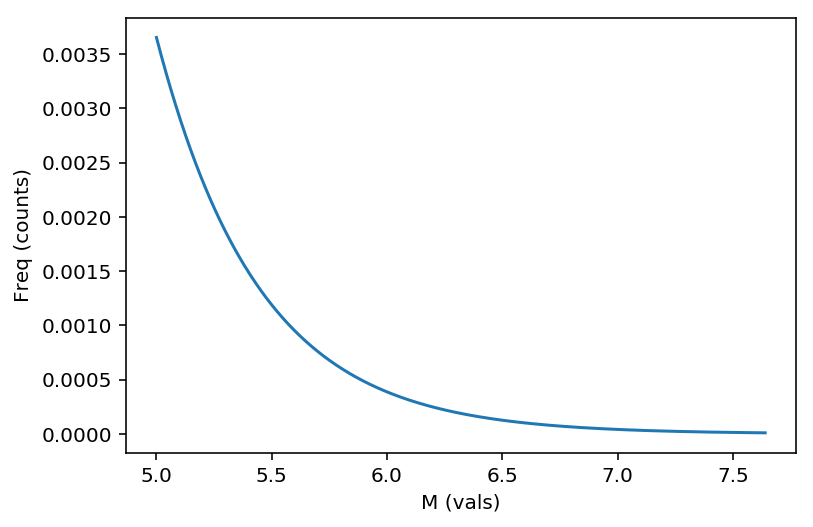

In [7]:
plot(M_vec, F_Mvec)
xlabel('M (vals)')
ylabel('Freq (counts)')

### Sample from F(M) with inverse transform sampling algorithm

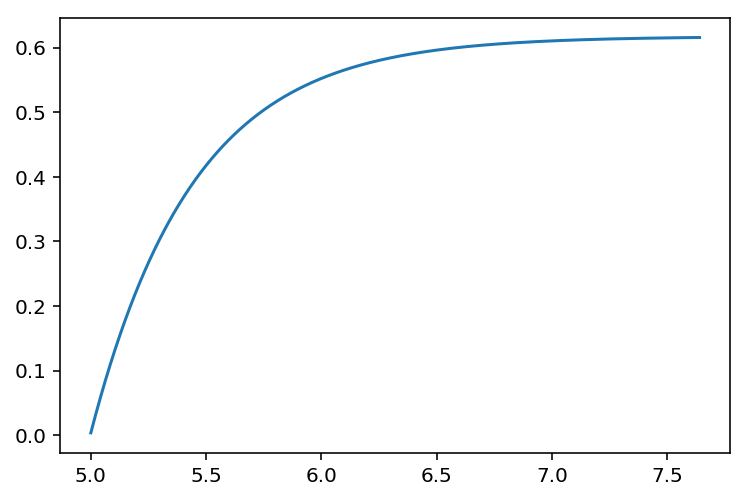

In [8]:
plot(M_vec, np.cumsum(F_Mvec) )

#### Define an algorithm to do inverse transform sampling.

In order to not have to fit a curve to the ECDF for sampling,
we will instead round incoming random values to the points
closest to them in the ECDF.  Shady, I know, but...  It also
allows for sampling from arbitrary PDFs, not ones that just look
like some simple function.

In [9]:
def get_ecdf(counts, norm=True):
    """Calculates an array sort of like an ECDF, but no x reference"""
    if norm == True:
        ecdf = np.cumsum(counts) / np.float(np.sum(counts))
    else:
        ecdf = np.cumsum(counts)
    
    return ecdf


def get_ecdf_dict(vals=None, counts=None, norm=True):
    """
    Returns a dict object linking counts to values.
    Things better be sorted!
    """
    ecdf = get_ecdf(counts, norm=norm)
    ecdf_dict = {}
    
    for i, val in enumerate(vals):
        ecdf_dict[val] = ecdf[i]
    
    return ecdf_dict


def get_inverse_ecdf_dict(vals=None, counts=None, norm=True):
    
    ecdf_dict = get_ecdf_dict(vals, counts, norm)
    inv_ecdf_dict = {y:x for x,y in ecdf_dict.iteritems()}
    
    return inv_ecdf_dict
    

def find_nearest_dict_val(dict_, vals):
    key_array = np.array(dict_.keys())
    nearest_vals = np.empty(vals.shape)
    
    for i, val in enumerate(vals):
        idx = (np.abs(key_array - val)).argmin()
        nearest_vals[i] = dict_[ key_array[idx] ]
    
    return nearest_vals

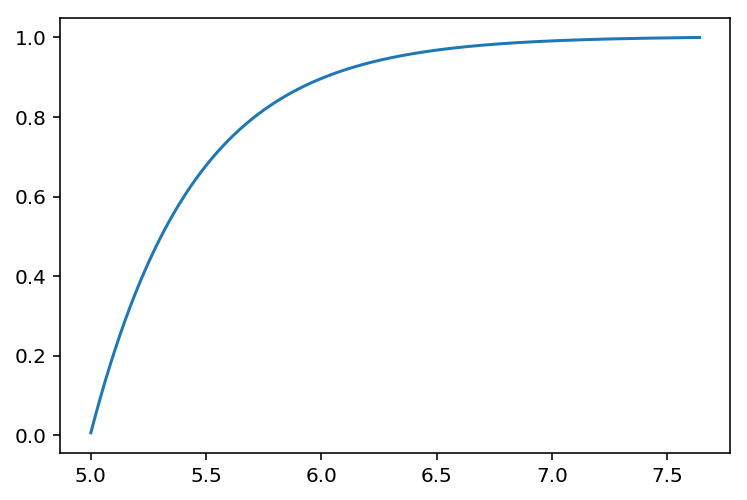

In [10]:
plot(M_vec, get_ecdf(F_Mvec))

In [11]:
ECDF_dict = get_ecdf_dict(vals=M_vec, counts=F_Mvec, norm=True)

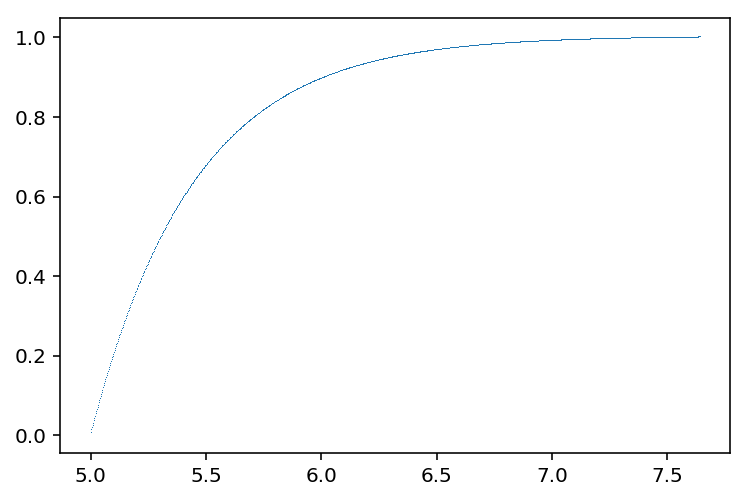

In [12]:
plot(ECDF_dict.keys(), ECDF_dict.values(), ',')

In [16]:
inv_ecdf_dict = get_inverse_ecdf_dict(vals=M_vec, counts=F_Mvec, norm=True)

In [17]:
rand_samp = np.random.rand(int(1e4))

In [18]:
freq_mag_samp = find_nearest_dict_val(inv_ecdf_dict, rand_samp)

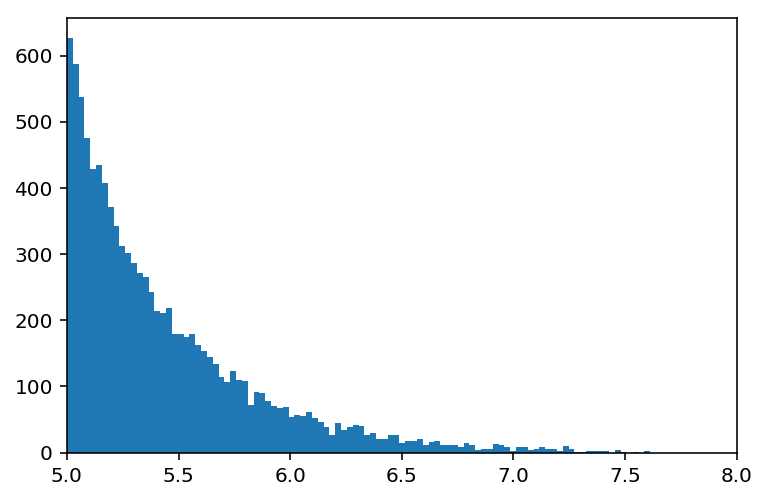

In [19]:
hist(freq_mag_samp, bins=100)
xlim(5,8)

show()

## Trial for South Lunggar

#### Get info for South Lunggar Detachment

In [20]:
slr = f.loc['s_lunggar']

In [21]:
slr

region            tibet
L_km                 20
z_km                 10
slip_rate_mm_a      2.5
sr_err_mm_a         0.5
dip_deg              22
dip_err_deg           5
Name: s_lunggar, dtype: object

#### Make dataframe for S. Lunggar MC trial

In [31]:
n_rand = int(1e5)

In [23]:
SLR_MC = pd.DataFrame(index=np.arange(n_rand), columns=['M', 'Mo', 'Ddot', 'dip', 'recur_int'])

#### Get random EQ values (M and Mo) from F(M) distribution

In [25]:
FM_icdf_d = get_inverse_ecdf_dict(vals=M_vec, counts=F_Mvec, norm=True)

SLR_MC['M']= find_nearest_dict_val(FM_icdf_d, np.random.rand(int(n_rand)) )

In [26]:
def Mo_from_M(M, C=6):
    """
    Calculate seismic moment (Mo) from
    moment magnitude (M) given a scaling law
    """
    term1 = 3/2. * C * (np.log(2) + np.log(5) )
    term2 = 3/2. * M * (np.log(2) + np.log(5) )
    
    Mo = np.exp( term1 + term2)
    
    return Mo

In [30]:
SLR_MC['Mo'] = Mo_from_M(SLR_MC.M)

#### Get random samples from slip rate and dip distributions

In [32]:
SLR_MC['Ddot'] = (np.random.rand(n_rand) * 2 * slr['sr_err_mm_a'] 
                 + slr['slip_rate_mm_a'] - slr['sr_err_mm_a'] )

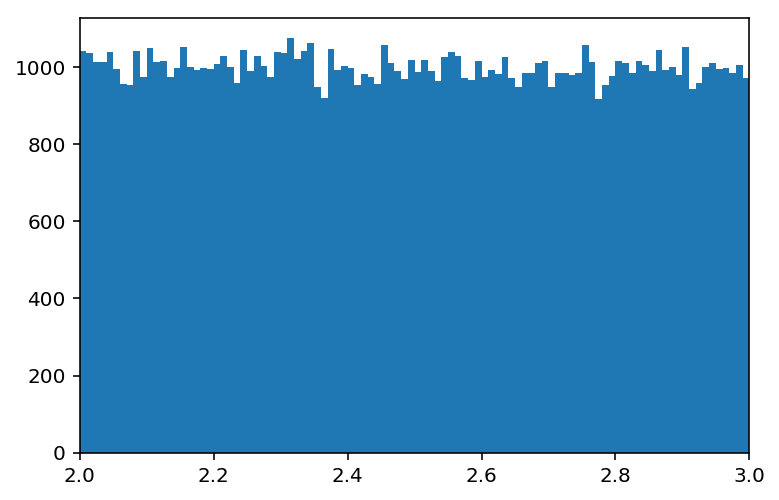

In [35]:
hist(SLR_MC.Ddot, bins=100)
xlim(2,3)
show()

In [36]:
SLR_MC.dip = (np.random.rand(n_rand) * 2 * slr['dip_err_deg'] 
             - slr['dip_err_deg'] + slr['dip_deg'] )

#### Calculate recurrence interval from Mo, fault geometry, slip rate

In [37]:
def calc_rec_int(Mo=None, dip=None, mu=6e9, L=None, z=None,
                 slip_rate=None):
    
    return Mo * np.sin(dip) / (mu * L * z * slip_rate)

In [38]:
SLR_MC.recur_int = calc_rec_int(Mo=SLR_MC.Mo, dip=np.radians(SLR_MC.dip), 
                                L=slr['L_km']*1000, z=slr['z_km']*1000, 
                                slip_rate=SLR_MC.Ddot/1000.)

In [39]:
np.median(SLR_MC.recur_int)

11.5554482941454

In [40]:
np.mean(SLR_MC.recur_int)

174.99568113802175

In [41]:
np.median(SLR_MC.M)

5.3065465465465467

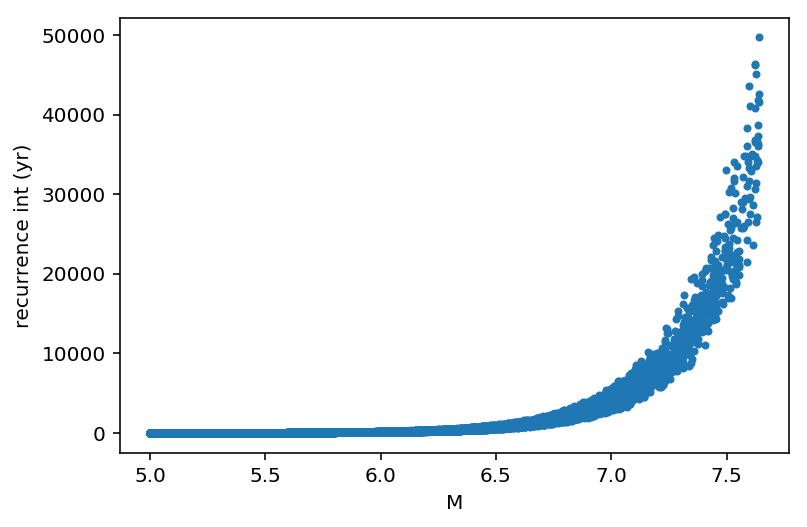

In [42]:
plot(SLR_MC.M, SLR_MC.recur_int, '.')
xlabel('M')
ylabel('recurrence int (yr)')

#### Calculate mean slip (D) for each event

In [43]:
SLR_MC['D_m'] = SLR_MC.Ddot / 1000. * SLR_MC.recur_int

In [44]:
SLR_MC.head()

,M,Mo,Ddot,dip,recur_int,D_m
0.0,5.266907,7.949876e+16,2.609596,21.609544,9.349391,0.024398
1.0,5.377898,1.166398e+17,2.372783,26.853290,18.503971,0.043906
2.0,5.983063,9.431800e+17,2.692230,17.425260,87.426305,0.235372
3.0,6.358318,3.447287e+18,2.076467,19.491127,461.611289,0.958521
4.0,5.142703,5.176713e+16,2.231533,24.190459,7.921562,0.017677


In [45]:
SLR_MC['cum_yrs'] = np.int_(np.cumsum( SLR_MC.recur_int.round() ) )

In [46]:
SLR_MC.head()

,M,Mo,Ddot,dip,recur_int,D_m,cum_yrs
0.0,5.266907,7.949876e+16,2.609596,21.609544,9.349391,0.024398,9
1.0,5.377898,1.166398e+17,2.372783,26.853290,18.503971,0.043906,28
2.0,5.983063,9.431800e+17,2.692230,17.425260,87.426305,0.235372,115
3.0,6.358318,3.447287e+18,2.076467,19.491127,461.611289,0.958521,577
4.0,5.142703,5.176713e+16,2.231533,24.190459,7.921562,0.017677,585


In [47]:
SLR_MC.cum_yrs.max()

17499706

from here I think I need to brute force the fuck out of things.

- Make a time series of EQs.  Zeros will be years with no EQs.  Non-zero years will be earthquake magnitudes.  The time from one earthquake to the next is the amount of time required to build up sufficient moment for the magnitude of the later earthquake.
- Then do a rolling maximum with a given time window (indicating period of observation) to calculate the number of time windows that have events larger than some magnitude threshold.

Maybe there is a better way to go about it, but I don't understand the statistical treatments.

In [48]:
eq_time_series = np.zeros(SLR_MC.cum_yrs.max())

In [49]:
for i in np.arange(n_rand-1):
    yr = SLR_MC.cum_yrs[i]
    mag = SLR_MC.M[i]
    eq_time_series[yr] = mag

In [50]:
eq_max_40yr = pd.rolling_max(eq_time_series, 40)

/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:1: FutureWarning: pd.rolling_max is deprecated for ndarrays and will be removed in a future version
  """Entry point for launching an IPython kernel.


In [51]:
def prob_above_val(series, val):
    count_above = len( series[series >= val])
    
    return count_above / float(len(series) )

In [52]:
prob_above_val(eq_max_40yr, 5.5)

/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in greater_equal
  


0.07118525305510846

In [53]:
window_prob_d = {}

In [54]:
min_eq_size = 6.5

In [55]:
for i in np.arange(100) + 1:
    eq_max_series = pd.rolling_max(eq_time_series, i)
    window_prob_d[i] = prob_above_val(eq_max_series, min_eq_size)


/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:2: FutureWarning: pd.rolling_max is deprecated for ndarrays and will be removed in a future version
  
/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in greater_equal
  


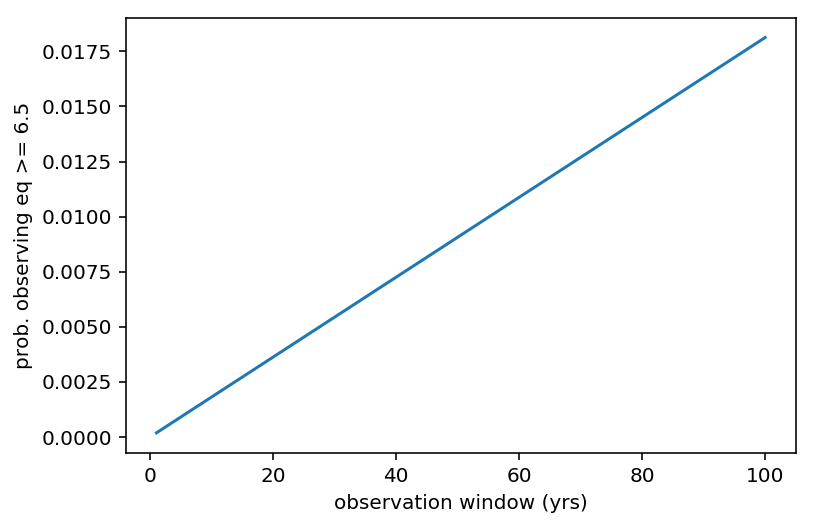

In [56]:
plot(window_prob_d.keys(), window_prob_d.values())
xlabel('observation window (yrs)')
ylabel('prob. observing eq >= {}'.format(min_eq_size) )

I think this is works.

## Define new F(M) that includes characteristic events

In [57]:
    def lognormal(x, mu = -0.5, sigma=0.5):
        term1 = 1 / sigma * x * np.sqrt(2 * np.pi)
        term2 = np.exp(-(np.log(x) - mu)**2 / (2 * sigma**2) )
        
        return term1 * term2
    
    
    def F_char(M, Mmin=2.5, Mc=7.64, B=0.65, char_M=6.25,
               char_amplitude_scale=5.25):
        """
        F(M) is the tapered Gutenberg-Richter distribution
        given by Shen et al., 2007 SRL with values for constants
        from the CRB values of Bird and Kagan 2004 BSSA.
        """
        Fm = F(M, Mmin=Mmin, Mc=Mc, B=B)
        F_char_amp = F(char_amplitude_scale)
        
        M_shift = M - char_M + 1
        M_shift[M_shift < 0] = 0
        
        F_lognormal = lognormal( (M_shift) )
        norm_constant = np.max(F_lognormal) / F_char_amp
        
        F_lognormal *= 1/ norm_constant
        
        F_char = Fm + F_lognormal
        
        F_char += - F_char.min()
        
        return F_char
    


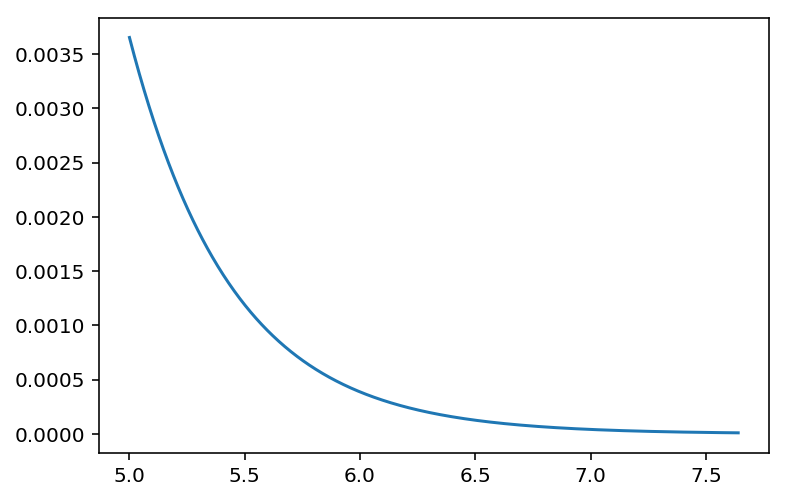

In [58]:
plot(M_vec, F(M_vec) )

/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:3: RuntimeWarning: divide by zero encountered in log
  This is separate from the ipykernel package so we can avoid doing imports until


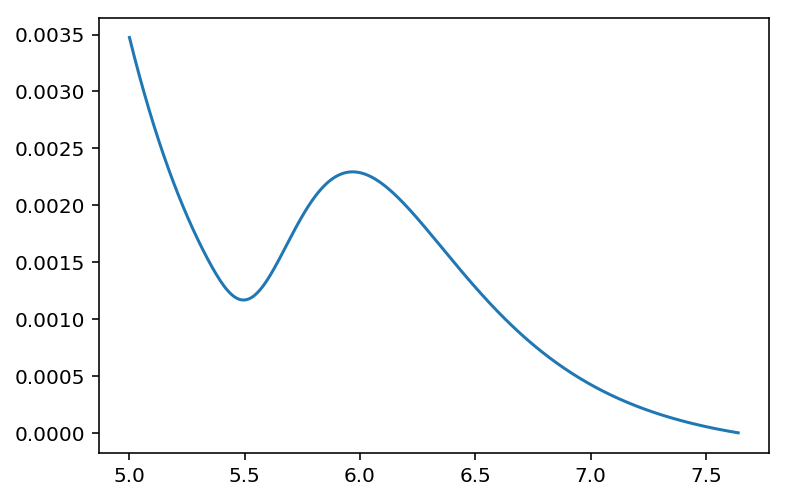

In [60]:
plot(M_vec, F_char(M_vec) )

schweet.

### Now let's do this for S. Lunggar again.

Make GB+characteristic F(M) distribution, and sample from it

In [61]:
SLR_CH_MC = pd.DataFrame(index=np.arange(n_rand), columns=SLR_MC.columns)

In [62]:
FM_char = F_char(M_vec, char_amplitude_scale=5.25)

/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:3: RuntimeWarning: divide by zero encountered in log
  This is separate from the ipykernel package so we can avoid doing imports until


In [63]:
FM_char_icdf_d = get_inverse_ecdf_dict(vals=M_vec, counts=FM_char, norm=True)

SLR_CH_MC.M = find_nearest_dict_val(FM_char_icdf_d, np.random.rand(n_rand) )

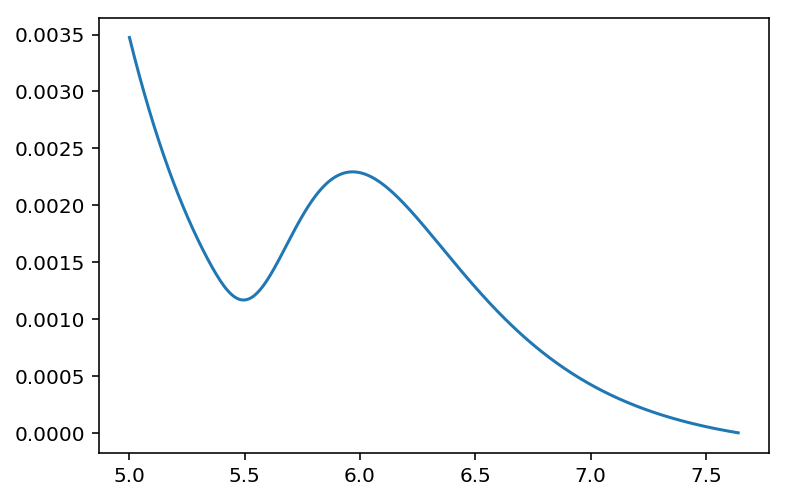

In [64]:
plot(M_vec, FM_char)

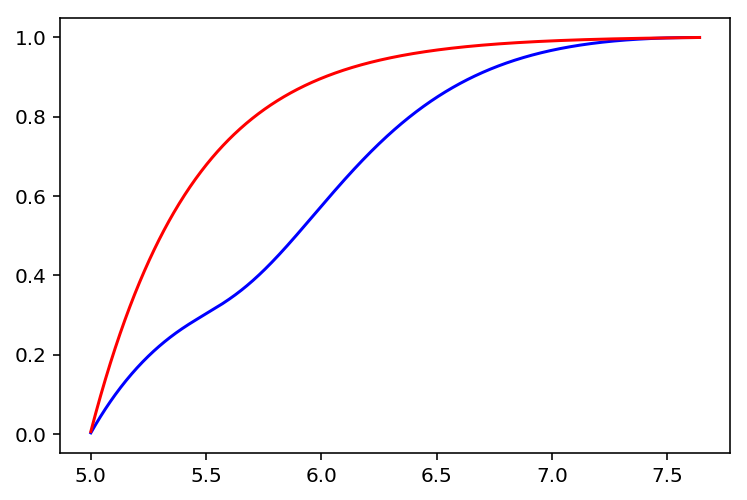

In [66]:
plot(M_vec, get_ecdf(FM_char) , 'b')
plot(M_vec, get_ecdf(F_Mvec), 'r')

(5, 8)

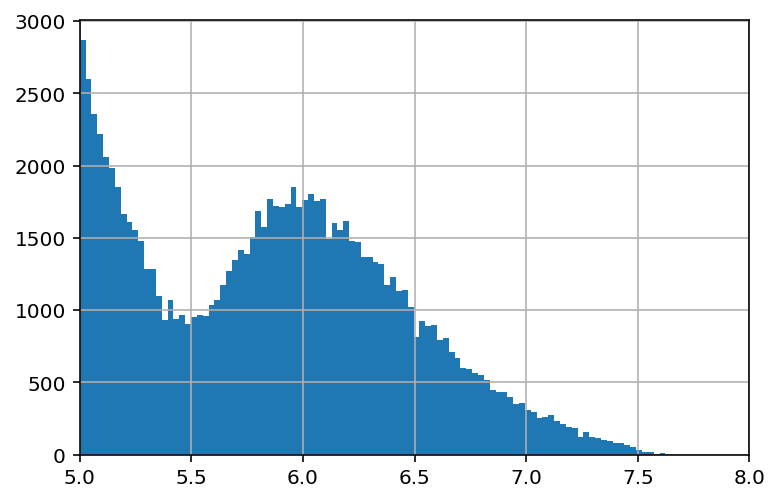

In [68]:
SLR_CH_MC.M.hist(bins=100)
xlim(5,8)

Calculate Mo and recurrence interval distribution

In [69]:
SLR_CH_MC.Mo = Mo_from_M(SLR_CH_MC.M)

SLR_CH_MC['Ddot'] = (np.random.rand(n_rand) * slr['sr_err_mm_a'] 
                     - slr['sr_err_mm_a']/2. + slr['slip_rate_mm_a'] )

SLR_CH_MC.dip = (np.random.rand(n_rand) * slr['dip_err_deg'] 
                 - slr['dip_err_deg']/2. + slr['dip_deg'] )

In [70]:
SLR_CH_MC.recur_int = calc_rec_int(Mo=SLR_CH_MC.Mo, dip=np.radians(SLR_CH_MC.dip), 
                                  L=slr['L_km']*1000, z=slr['z_km']*1000, 
                                  slip_rate=SLR_CH_MC.Ddot/1000.)

In [71]:
np.median(SLR_CH_MC.recur_int)

83.421226395800815

In [72]:
np.mean(SLR_CH_MC.recur_int)

573.85817075663067

In [73]:
SLR_CH_MC['cum_yrs'] = np.int_(np.cumsum( SLR_CH_MC.recur_int.round() ) )

In [74]:
SLR_CH_MC.cum_yrs.max()

57385782

In [75]:
ch_eq_time_series = np.zeros(SLR_CH_MC.cum_yrs.max())

In [76]:
for i in np.arange(n_rand-1):
    yr = SLR_CH_MC.cum_yrs[i]
    mag = SLR_CH_MC.M[i]
    ch_eq_time_series[yr] = mag

In [77]:
ch_window_prob_d = {}

In [78]:
for i in np.arange(100) + 1:
    eq_max_series = pd.rolling_max(ch_eq_time_series, i)
    ch_window_prob_d[i] = prob_above_val(eq_max_series, min_eq_size)

/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:2: FutureWarning: pd.rolling_max is deprecated for ndarrays and will be removed in a future version
  
/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in greater_equal
  


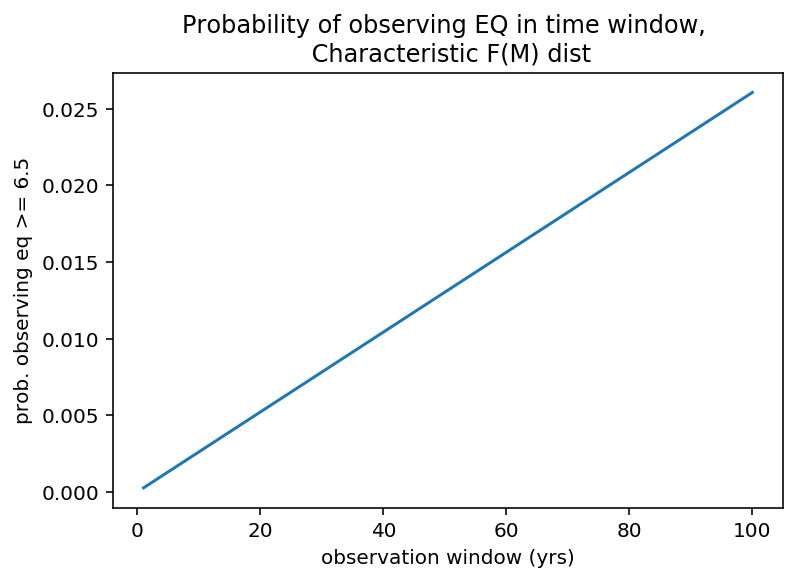

In [79]:
plot(ch_window_prob_d.keys(), ch_window_prob_d.values())
xlabel('observation window (yrs)')
ylabel('prob. observing eq >= {}'.format(min_eq_size) )
title('Probability of observing EQ in time window, \n Characteristic F(M) dist')

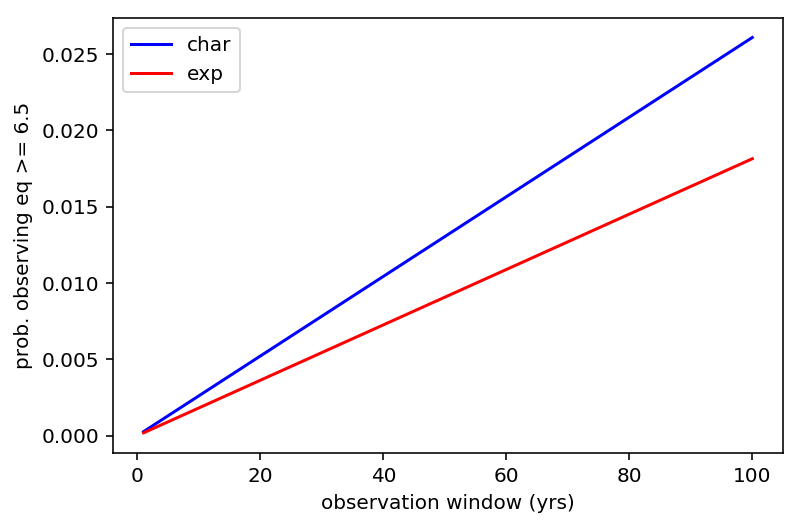

In [80]:
plot(ch_window_prob_d.keys(), ch_window_prob_d.values(), 'b', label='char')
plot(window_prob_d.keys(), window_prob_d.values(), 'r', label='exp')
xlabel('observation window (yrs)')
ylabel('prob. observing eq >= {}'.format(min_eq_size) )
legend(loc='upper left')

show()

This is a result.  Is it intuitive, that we are less likely to see a large earthquake over some time series if the earthquakes have a characteristic F(M) distribution vs. an exponential (GB) distribution?

I was a little surprised, but I think it has to do with the way the sampling is done (which I would not say is wrong).  Basically, my interpretation is that the time series is longer in the characteristic sequence (by 2 million years), so there is more 'empty' time, meaning that the probability of seeing an earthquake is less.

But I don't know...

I think that the differences are small enough that it doesn't matter.

dtype('float64')